In [72]:
import pandas as pd

In [73]:
train_data = pd.read_csv('train.csv')
train_data.shape

(26570, 26)

In [74]:
#check for missing values
all_nulls = train_data.isnull().sum()
all_nulls[all_nulls > 0]

loading            250
measurement_3      381
measurement_4      538
measurement_5      676
measurement_6      796
measurement_7      937
measurement_8     1048
measurement_9     1227
measurement_10    1300
measurement_11    1468
measurement_12    1601
measurement_13    1774
measurement_14    1874
measurement_15    2009
measurement_16    2110
measurement_17    2284
dtype: int64

In [75]:
# Percentage of values missing
len(train_data) * len(train_data.columns)/sum(all_nulls)

34.07586445025403

In [76]:
train_data.head()

,id,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,...,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
0,0,A,80.10,material_7,material_8,9,5,7,8,4,...,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100,0
1,1,A,84.89,material_7,material_8,9,5,14,3,3,...,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0
2,2,A,82.43,material_7,material_8,9,5,12,1,5,...,12.715,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376,0
3,3,A,101.07,material_7,material_8,9,5,13,2,6,...,12.471,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282,0
4,4,A,188.06,material_7,material_8,9,5,9,2,8,...,10.337,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885,0


c:\Users\vidul\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='failure', ylabel='count'>

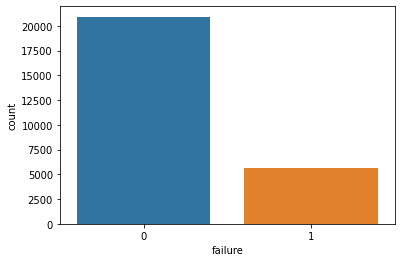

In [77]:
import seaborn as sns

sns.countplot(train_data['failure'])

In [78]:
y = train_data['failure']
train_data = train_data.drop(['failure'], axis=1)

In [79]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_data, y, test_size=0.2, random_state=42, stratify=y)

In [80]:
#get string columns pandas
col_strings = train_data.select_dtypes(exclude=[int,float]).columns
col_strings

Index(['product_code', 'attribute_0', 'attribute_1'], dtype='object')

In [81]:
num_cols = train_data.select_dtypes(include=[float,int]).columns
num_cols

Index(['id', 'loading', 'attribute_2', 'attribute_3', 'measurement_0',
       'measurement_1', 'measurement_2', 'measurement_3', 'measurement_4',
       'measurement_5', 'measurement_6', 'measurement_7', 'measurement_8',
       'measurement_9', 'measurement_10', 'measurement_11', 'measurement_12',
       'measurement_13', 'measurement_14', 'measurement_15', 'measurement_16',
       'measurement_17'],
      dtype='object')

In [82]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler
# Presprocessing

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

int_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

float_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])

preprocessor = ColumnTransformer(
    [
        ('cat', categorical_transformer, col_strings),
        ('int', int_transformer, train_data.select_dtypes(include=[int]).columns),
        ('float', float_transformer, num_cols)
    ])

In [83]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [49]:
X_test

array([[0.        , 0.        , 1.        , ..., 0.43107861, 0.39380106,
        0.52998757],
       [0.        , 0.        , 0.        , ..., 0.51489945, 0.57944898,
        0.39586651],
       [0.        , 0.        , 0.        , ..., 0.36471664, 0.34142239,
        0.38453377],
       ...,
       [0.        , 0.        , 0.        , ..., 0.4226691 , 0.65489348,
        0.42282249],
       [0.        , 0.        , 0.        , ..., 0.44369287, 0.57864809,
        0.38034895],
       [0.        , 0.        , 0.        , ..., 0.35146252, 0.54364889,
        0.52114026]])

In [50]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [91]:
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(20, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(15, activation='relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss = tf.keras.losses.BinaryFocalCrossentropy(), optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3), metrics = [tf.keras.metrics.AUC()])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 20)                780       
                                                                 
 dense_15 (Dense)            (None, 15)                315       
                                                                 
 dropout_4 (Dropout)         (None, 15)                0         
                                                                 
 dense_16 (Dense)            (None, 10)                160       
                                                                 
 dense_17 (Dense)            (None, 1)                 11        
                                                                 
Total params: 1,266
Trainable params: 1,266
Non-trainable params: 0
_________________________________________________________________


In [52]:
# plot learning curve
# summarize history for accuracy
def plot_history_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
def plot_history_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

def plot_history_auc(history,num):
    plt.plot(history.history['auc_' + num])
    plt.plot(history.history['val_auc_' + num])
    plt.title('Model AUC')
    plt.ylabel('auc')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [60]:
history_means = model.fit(X_train, y_train,epochs = 100, validation_data=(X_test,y_test), callbacks=[tf.keras.callbacks.EarlyStopping(patience=25,restore_best_weights=True)]) #

Epoch 1/100
665/665 [==============================] - 6s 8ms/step - loss: 0.1358 - auc_3: 0.5053 - val_loss: 0.1341 - val_auc_3: 0.5168
Epoch 2/100
665/665 [==============================] - 5s 8ms/step - loss: 0.1339 - auc_3: 0.5127 - val_loss: 0.1334 - val_auc_3: 0.5201
Epoch 3/100
665/665 [==============================] - 7s 10ms/step - loss: 0.1334 - auc_3: 0.5269 - val_loss: 0.1327 - val_auc_3: 0.5682
Epoch 4/100
665/665 [==============================] - 6s 8ms/step - loss: 0.1328 - auc_3: 0.5508 - val_loss: 0.1322 - val_auc_3: 0.5743
Epoch 5/100
665/665 [==============================] - 6s 9ms/step - loss: 0.1324 - auc_3: 0.5649 - val_loss: 0.1322 - val_auc_3: 0.5815
Epoch 6/100
665/665 [==============================] - 5s 8ms/step - loss: 0.1324 - auc_3: 0.5637 - val_loss: 0.1323 - val_auc_3: 0.5830
Epoch 7/100
665/665 [==============================] - 5s 8ms/step - loss: 0.1321 - auc_3: 0.5693 - val_loss: 0.1318 - val_auc_3: 0.5805
Epoch 8/100
665/665 [===================

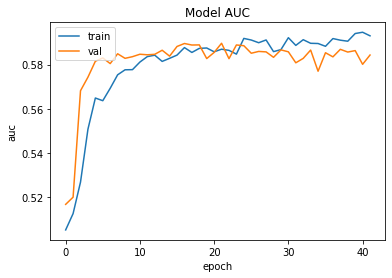

In [61]:
plot_history_auc(history_means,'3')

In [55]:
best_auc = 0.587196946144104

In [62]:
best_metrics = model.evaluate(X_test, y_test)
if best_metrics[1] > best_auc:
    best_auc = best_metrics[1]
    best_model = model.save('best_model')
best_metrics[1]

167/167 [==============================] - 1s 4ms/step - loss: 0.1314 - auc_3: 0.5896
INFO:tensorflow:Assets written to: best_model\assets


0.5895617008209229

In [93]:
#train on all data
best_model = tf.keras.models.load_model('best_model')
all_data = preprocessor.transform(train_data)

final_model = model.fit(all_data, y,epochs = 100, callbacks=[tf.keras.callbacks.EarlyStopping(patience=30,restore_best_weights=True,monitor = 'auc_4')]) #

Epoch 1/100
831/831 [==============================] - 5s 7ms/step - loss: 0.1329 - auc_4: 0.5459
Epoch 2/100
831/831 [==============================] - 6s 7ms/step - loss: 0.1326 - auc_4: 0.5555
Epoch 3/100
831/831 [==============================] - 6s 7ms/step - loss: 0.1323 - auc_4: 0.5649
Epoch 4/100
831/831 [==============================] - 6s 7ms/step - loss: 0.1321 - auc_4: 0.5695
Epoch 5/100
831/831 [==============================] - 6s 7ms/step - loss: 0.1318 - auc_4: 0.5783
Epoch 6/100
831/831 [==============================] - 6s 7ms/step - loss: 0.1318 - auc_4: 0.5790
Epoch 7/100
831/831 [==============================] - 6s 7ms/step - loss: 0.1318 - auc_4: 0.5810
Epoch 8/100
831/831 [==============================] - 5s 6ms/step - loss: 0.1316 - auc_4: 0.5842
Epoch 9/100
831/831 [==============================] - 5s 6ms/step - loss: 0.1317 - auc_4: 0.5819
Epoch 10/100
831/831 [==============================] - 5s 6ms/step - loss: 0.1317 - auc_4: 0.5842
Epoch 11/100
831/83

KeyError: 'val_auc_4'

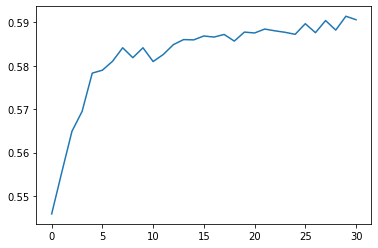

In [94]:
plot_history_auc(final_model,'4')

In [98]:
test_data = pd.read_csv('test.csv')
test_data.head()

,id,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,...,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17
0,26570,F,119.57,material_5,material_6,6,4,6,9,6,...,18.654,10.802,15.909,18.070,13.772,13.659,16.825,13.742,17.710,634.612
1,26571,F,113.51,material_5,material_6,6,4,11,8,0,...,19.368,12.032,13.998,NaN,12.473,17.468,16.708,14.776,14.102,537.037
2,26572,F,112.16,material_5,material_6,6,4,8,12,4,...,17.774,11.743,17.046,18.086,10.907,13.363,15.737,17.065,16.021,658.995
3,26573,F,112.72,material_5,material_6,6,4,8,11,10,...,18.948,11.790,18.165,16.163,10.933,15.501,15.667,12.620,16.111,594.301
4,26574,F,208.00,material_5,material_6,6,4,14,16,8,...,19.141,12.370,14.578,17.849,11.941,16.070,16.183,13.324,17.150,801.044


In [99]:
test_data.shape

(20775, 25)

In [101]:
x_real_test = preprocessor.transform(test_data)
test_data_predict_prob = model.predict(x_real_test)

test_data_predict_prob = test_data_predict_prob.flatten()

650/650 [==============================] - 1s 2ms/step


In [102]:
output = pd.DataFrame({'id': test_data['id'],
                       'failure': test_data_predict_prob})
output.to_csv('submission.csv', index=False)

In [103]:
output.head()

,id,failure
0,26570,0.404935
1,26571,0.395574
2,26572,0.403809
3,26573,0.401213
4,26574,0.408812
